In [1]:
!pip install mcap-ros2-support mcap

Defaulting to user installation because normal site-packages is not writeable
  Using cached mcap_ros2_support-0.5.3-py3-none-any.whl (26 kB)
  Using cached mcap-1.1.1-py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 10.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00a 0:00:01


In [2]:
import math

In [3]:
from mcap_ros2.decoder import DecoderFactory
from mcap.reader import make_reader

magnetometer_data = []
printer_data = []
with open(
    "../data/rosbag2_2024_01_11-11_38_41/rosbag2_2024_01_11-11_38_41_0.mcap",
    "rb",
) as fd:
    reader = make_reader(fd, decoder_factories=[DecoderFactory()])
    for schema, channel, message, ros_msg in reader.iter_decoded_messages(
    ):
        # print(f"{channel.topic} {schema.name} [{message.log_time}]: ")
        if channel.topic == "/magnetometer_reading":
            for reading in ros_msg.magnetic_field_array:
                timestamp = reading.header.stamp.sec + reading.header.stamp.nanosec * 1e-9
                magnetic_field_x = reading.magnetic_field.x
                magnetic_field_y = reading.magnetic_field.y
                magnetic_field_z = reading.magnetic_field.z
                magnetometer_data.append([timestamp, magnetic_field_x, magnetic_field_y, magnetic_field_z])

        elif channel.topic == "/tf":
            for transform in ros_msg.transforms:
                if transform.header.frame_id == "printer_head_link":
                    timestamp = transform.header.stamp.sec + transform.header.stamp.nanosec * 1e-9
                    x = transform.transform.translation.x
                    y = transform.transform.translation.y
                    z = transform.transform.translation.z
                    printer_data.append([timestamp, x, y, z])

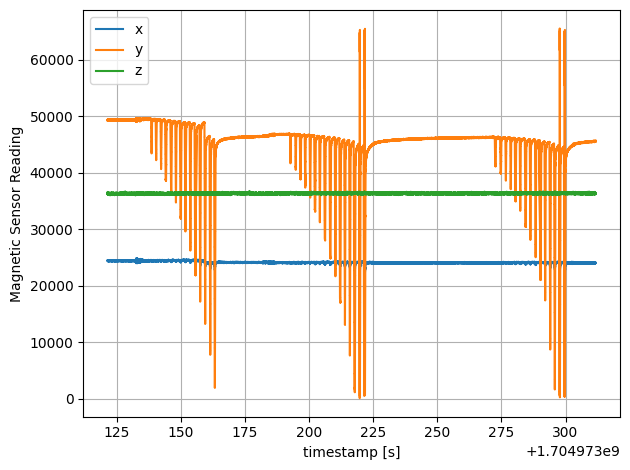

In [26]:
from matplotlib import pyplot as plt

plt.plot([x[0] for x in magnetometer_data], [x[1] for x in magnetometer_data], label="x")
plt.plot([x[0] for x in magnetometer_data], [x[2] for x in magnetometer_data], label="y")
plt.plot([x[0] for x in magnetometer_data], [x[3] for x in magnetometer_data], label="z")
plt.gca().set_xlabel("timestamp [s]")
plt.gca().set_ylabel("Magnetic Sensor Reading")
plt.legend()
plt.grid()
plt.tight_layout()
plt.gcf().savefig("../../reports/ros_integration/figures/raw_magnetometer.png")

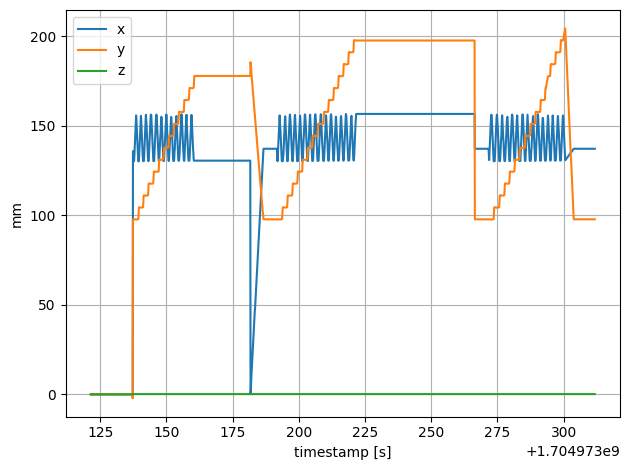

In [27]:
plt.plot([x[0] for x in printer_data], [x[1] for x in printer_data], label="x")
plt.plot([x[0] for x in printer_data], [x[2] for x in printer_data], label="y")
plt.plot([x[0] for x in printer_data], [x[3] for x in printer_data], label="z")
plt.gca().set_xlabel("timestamp [s]")
plt.gca().set_ylabel("mm")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/3d_printer_raw.png")


In [9]:
import numpy as np
from scipy.signal import butter,filtfilt

# Filter requirements.
T = 5.0         # Sample Period
fs = 850       # sample rate, Hz
cutoff = 2     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
# n = len(y_data) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # print(b.dtype, a.dtype)
    y = filtfilt(b, a, data)
    return y

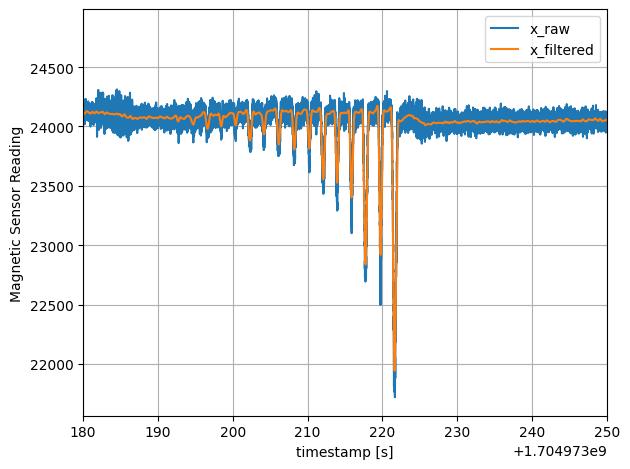

In [28]:
t_data = [x[0] for x in magnetometer_data]
x_data = [x[1] for x in magnetometer_data]
x_filtered = butter_lowpass_filter(x_data, cutoff, fs, order)

plt.plot(t_data, x_data, label="x_raw")
plt.plot(t_data, x_filtered, label="x_filtered")
plt.gca().set_xlabel("timestamp [s]")
plt.gca().set_ylabel("Magnetic Sensor Reading")
plt.xlim([x + 1.704973e9 for x in (180, 250)])
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/filtered_magnetometer.png")

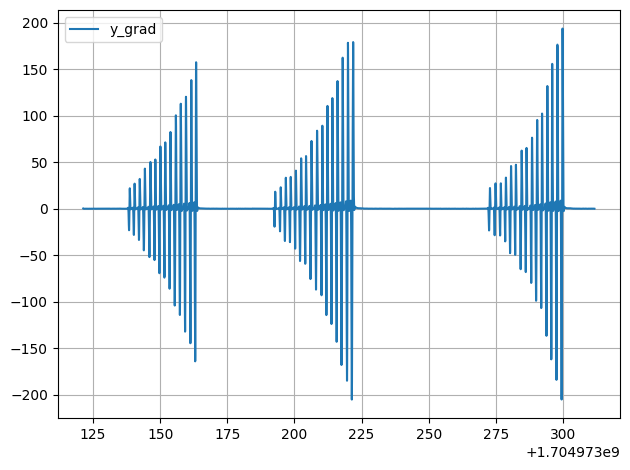

In [29]:
# get gradient of sensor data
import numpy as np

y_data = [float(x[2]) for x in magnetometer_data]
for i in range(len(y_data)):
    if y_data[i] > 55000:
        y_data[i] = y_data[i] - 2**16
y_filtered = butter_lowpass_filter(y_data, cutoff, fs, order)
y_grad = np.gradient(y_filtered)

plt.plot([x[0] for x in magnetometer_data], y_grad, label="y_grad")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/y_grad.png")


In [19]:
episodes = []
open_episode = True
episode_start = 0

t_data = [x[0] for x in magnetometer_data]

print(len(y_grad), len(t_data))
for idx, pt in enumerate(y_grad):
    if open_episode:
        if pt < -10:
            # found start of episode
            open_episode = False
            episode_start = t_data[idx]
        else:
            continue
    else:
        if pt > 10:
            # found end of episode
            open_episode = True
            episodes.append((episode_start, t_data[idx]))
        else:
            continue

169063 169063


45
[144.10500000000002, 137.43, 130.76, 124.105, 117.44, 110.75, 104.10000000000001, 97.40499999999999, 90.75500000000001, 84.09500000000001, 77.425, 70.74499999999999, 63.94, 63.94, 144.115, 137.44, 130.78, 124.11, 117.44, 110.78500000000001, 104.10000000000001, 97.44, 90.76, 84.075, 77.43, 70.75, 64.09500000000001, 57.41999999999999, 50.75, 44.09, 144.12, 137.45499999999998, 130.775, 124.105, 117.445, 110.77, 104.11000000000001, 97.425, 90.76, 84.105, 77.425, 66.355, 57.415000000000006, 50.75, 44.08000000000001]
[-23.11946391671154, -28.16764821689867, -33.59154098519866, -44.77838601433905, -52.0248860390202, -55.22117131634877, -69.3679940919501, -74.10789889088119, -86.0555132638001, -104.13708907711771, -114.27234984318056, -132.20626530675872, -144.7041407488814, -164.1431724734739, -19.30347881216221, -24.268757152916805, -34.72712862047047, -35.924465005886304, -42.948327138932655, -56.25381771992397, -59.20544621033696, -75.6608263236376, -87.00447370282927, -93.0711751472590

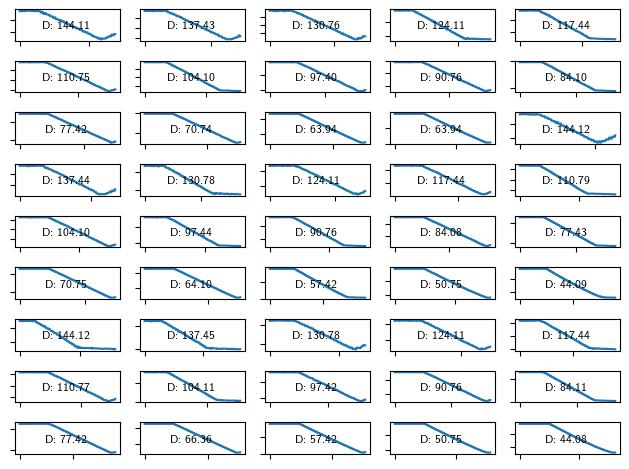

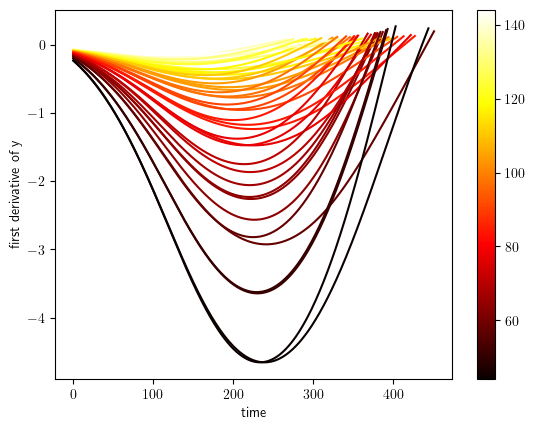

In [67]:
shaft_timestamp = [x[0] for x in printer_data]

BEAM_EDGE_Y_RELATIVE_TO_NOZZLE = 56.75
WHISKER_TIP_Y = 35  # from the base of the printer bed


def distance_on_shaft(y):
    return 150 - (y - BEAM_EDGE_Y_RELATIVE_TO_NOZZLE - WHISKER_TIP_Y)


shaft_data = [distance_on_shaft(x[2]) for x in printer_data]


shaft_data_zipped = list(zip(shaft_timestamp, shaft_data))
shaft_data_per_episode = []

episodes_data = []
episodes_grad_data = []
for episode_start, episode_end in episodes:
    episodes_data.append(
        [y for t, y in zip(t_data, y_data) if t >= episode_start and t <= episode_end]
    )
    shaft_data_per_episode.append(
        [
            x[1]
            for x in shaft_data_zipped
            if x[0] >= episode_start and x[0] <= episode_end
        ]
    )
    episodes_grad_data.append(
        [y for t, y in zip(t_data, y_grad) if t >= episode_start and t <= episode_end]
    )

shaft_distance_per_episode = [float(np.median(x)) for x in shaft_data_per_episode]

print(len(episodes_data))
fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
for idx, data in enumerate(episodes_data):
    ax = axes[idx // 5, idx % 5]
    ax.plot(data)
    ax.set_title(
        f"D: {shaft_distance_per_episode[idx]:.2f}", y=1.0, pad=-14, fontsize=8
    )

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("../../reports/ros_integration/figures/episodes_y_data.png")

# fig, axes = plt.subplots(ncols=5, nrows=math.ceil(len(episodes) / 5))
# for idx, data in enumerate(episodes_grad_data):
#     ax = axes[idx // 5, idx % 5]
#     ax.plot(data)
#     ax.set_title(f"D: {shaft_distance_per_episode[idx]:.2f}")

#     ax.axes.xaxis.set_ticklabels([])
#     ax.axes.yaxis.set_ticklabels([])
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(
    vmin=min(shaft_distance_per_episode), vmax=max(shaft_distance_per_episode)
)
cmap = cm.hot
x = 0.3

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
for idx, data in enumerate(episodes_grad_data):
    d = shaft_distance_per_episode[idx]
    plt.plot(
        [data/d for data in data],
        label=f"{d:.2f}",
        color=m.to_rgba(d),
    )

plt.rcParams['text.usetex'] = True
plt.gca().set_xlabel("time")
plt.gca().set_ylabel("first derivative of y")
plt.colorbar(m, ax=plt.gca())
plt.savefig("../../reports/ros_integration/figures/corrected_derivative.png")

max_grad_per_episode = [np.min(x) for x in episodes_grad_data]
print(shaft_distance_per_episode)
print(max_grad_per_episode)

45 45


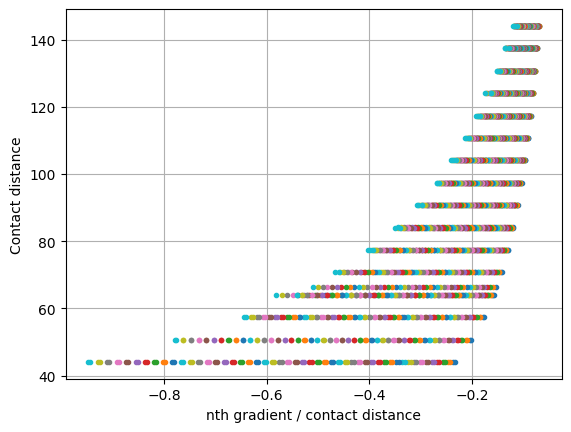

In [62]:
tenth_grad_per_episode = [x[10] for x in episodes_grad_data]

print(len(shaft_distance_per_episode), len(tenth_grad_per_episode))

for n in range(50):
    nth_grad_per_episode = [x[n] for x in episodes_grad_data]
    plt.plot([x/d for x,d in zip(nth_grad_per_episode,shaft_distance_per_episode)], shaft_distance_per_episode, ".")
plt.xlabel("nth gradient / contact distance")
plt.ylabel("Contact distance")
plt.grid()


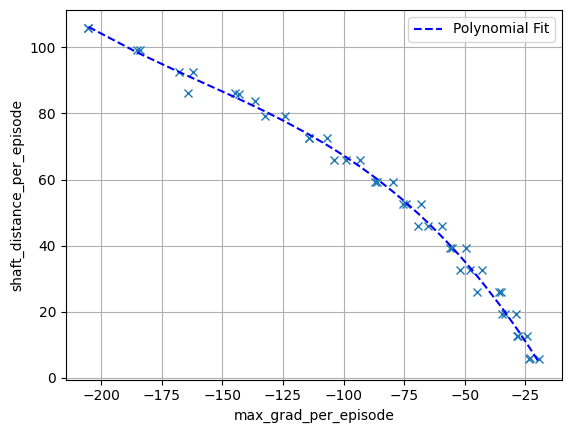

In [41]:
# curve-fit() function imported from scipy
from scipy.optimize import curve_fit

def whisker_model(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d
 
param, param_cov = curve_fit(whisker_model, max_grad_per_episode, shaft_distance_per_episode)
 
plt.plot([x for x in max_grad_per_episode], shaft_distance_per_episode, "x")
plt.grid()

ans = [whisker_model(x, param[0], param[1], param[2], param[3]) for x in sorted(max_grad_per_episode)]

plt.plot(sorted(max_grad_per_episode), ans, '--', color ='blue', label ="Polynomial Fit")
plt.gca().set(xlabel='max_grad_per_episode', ylabel='shaft_distance_per_episode')
plt.legend()
plt.show()

In [ ]:
import pickle

with open("whisker_model.pkl", "wb") as fd:
    pickle.dump(param, fd)

: 

In [ ]:
with open("whisker_model.pkl", "rb") as fd:
    print(pickle.load(fd))

: 

In [ ]:
for idx, data in enumerate(episodes_data):
    print(len(data))

: 

: 